# Tutorial 2

Thara Caba \
April 26 2024

## BPT Diagram

__1)__ Use SDSS DR18 SQL search to find all galaxies which have only the narrow emission lines (FWHM<500 km/s), high median signal
to noise ratio in g band (S/N>40), and fluxes of lines: [O III] 5007, Hβ, Hα and [N II] 6583 larger than 5 e-17 erg/s/cm^2. Set criteria
so that the fluxes are larger than errors in flux multiplied with 5 in order to get good results. SQL output should be the fluxes of
these lines.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

`SELECT s.plate, s.mjd, s.fiberid, s.z, g.subclass, g.e_bv_sfd,` \
`l.h_alpha_flux, l.h_beta_flux, l.oiii_5007_flux, l.nii_6584_flux,`  
`w.w1mpro, w.w2mpro, w.w3mpro`\
`FROM SpecObjAll AS s `\
`JOIN GalSpecInfo AS g ON s.specobjid = g.specobjid `\
`JOIN GalSpecLine AS l ON s.specobjid = l.specobjid	`\
`JOIN wise_xmatch AS x ON s.bestobjid = x.sdss_objid`\
`JOIN wise_allsky AS w ON x.wise_cntr = w.cntr`\
`WHERE (s.class = "QSO" OR s.class = "GALAXY")`\
`AND s.snmedian_g > 40`\
`AND l.h_alpha_flux > 5`\
`AND l.h_alpha_flux/l.h_alpha_flux_err > 5`\
`AND l.h_beta_flux > 5`\
`AND l.h_beta_flux/l.h_beta_flux_err > 5`\
`AND l.oiii_5007_flux > 5`\
`AND l.oiii_5007_flux/l.oiii_5007_flux_err > 5`\
`AND l.nii_6584_flux > 5`\
`AND l.nii_6584_flux/l.nii_6584_flux_err > 5`\
`AND (l.sigma_balmer * 2.355) < 500`

In [5]:
from astroquery.sdss import SDSS

with open('query.txt', 'r') as file:
    query = file.read().replace('\n', ' ') ## input is a single string

results = SDSS.query_sql(query).to_pandas()

results

,plate,mjd,fiberid,z,subclass,e_bv_sfd,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,w1mpro,w2mpro,w3mpro
0,1666,52991,11,0.017784,AGN BROADLINE,0.180392,555.7126,162.12570,102.83580,404.6120,10.586,10.676,8.993
1,1309,52762,439,0.005701,STARFORMING,0.015393,1039.2140,175.08380,57.58485,423.8870,9.426,9.202,5.031
2,775,52295,410,0.010826,STARBURST,0.009580,5745.3640,1461.34500,1267.27900,1467.1250,14.356,14.195,9.871
3,564,52224,99,0.013246,STARFORMING,0.050521,1695.5870,501.81610,726.29080,347.2574,14.369,14.340,11.500
4,2241,54169,598,0.023741,BROADLINE,0.008973,117.6491,43.39046,253.74640,253.2280,13.261,13.236,11.737
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2134,53876,361,0.014400,BROADLINE,0.023690,315.1962,120.45240,191.52580,465.0980,10.403,10.457,9.421
1046,308,51662,191,0.005535,AGN,0.044501,803.5585,216.12770,345.87280,853.2526,10.203,10.221,8.550
1047,537,52027,240,0.005224,STARFORMING,0.037490,4874.0800,983.14730,551.11520,2755.9030,10.123,10.057,6.648
1048,536,52024,40,0.005190,STARFORMING,0.037490,4881.9670,840.70630,520.56640,2740.8870,10.123,10.057,6.648


__2)__ For the obtained sample make the diagnostic BPT (Baldwin,
Philips and Terlevich) diagram. This diagram determines the
dominant ionization source for the objects: accretion disk (AGN)
or hot emission stars (H II - star-burst region). For the BPT
diagram use the flux ratios of the lines: [O III] 5007/Hβ vs. [N
II]6583/Hα.

In [10]:
results['nii_h_alpha'] = results.apply(lambda x: x['nii_6584_flux'] / x['h_alpha_flux'], axis=1)
results['nii_h_alpha_log'] = results.apply(lambda x: np.log10(x['nii_h_alpha']), axis=1)
results['oiii_h_beta'] = results.apply(lambda x: x['oiii_5007_flux'] / x['h_beta_flux'], axis=1)
results['oiii_h_beta_log'] = results.apply(lambda x: np.log10(x['oiii_h_beta']), axis=1)

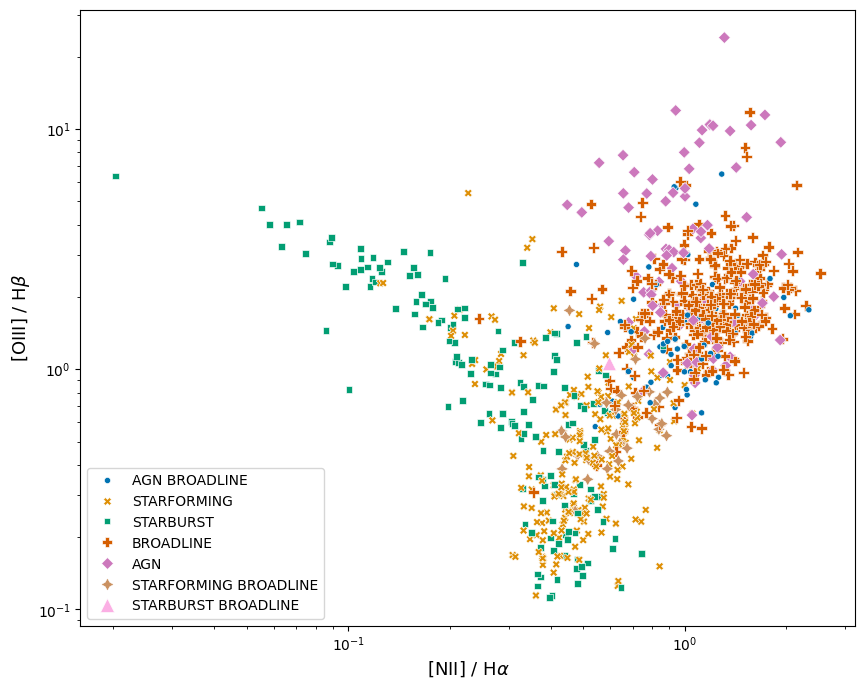

In [12]:
plt.figure(figsize=(10, 8))

sns.scatterplot(data=results, x='nii_h_alpha', y='oiii_h_beta', palette='colorblind', 
                hue='subclass', style='subclass', size='subclass', sizes=(100, 20))

plt.xlabel(r'[NII] / H$\alpha$', fontsize=13)
plt.ylabel(r'[OIII] / H$\beta$', fontsize=13)

plt.xscale('log')
plt.yscale('log')

plt.legend(loc='lower left', fontsize=10)

plt.show()

In [13]:
#Kauffman et al. 2003
def BPT_class_Kauff(oiii_h_beta, nii_h_alpha):
    # second condition is to avoid double lines
    if (np.log10(oiii_h_beta) < 0.61 / (np.log10(nii_h_alpha) - 0.05) + 1.3) and (np.log10(nii_h_alpha) < 0.0):
        return 'Star Forming'
    else:
        return 'AGN'

In [32]:
#Kewley et al. 2001
def BPT_class_Kew(oiii_h_beta, nii_h_alpha):
    if np.log10(oiii_h_beta) < 0.61 / (np.log10(nii_h_alpha) - 0.47) + 1.19:
        return 'Star Forming'
    else:
        return 'AGN'

In [26]:
results['BPT Kauffman'] = results.apply(lambda x: BPT_class_Kauff(x['oiii_h_beta'], x['nii_h_alpha']), axis=1)
results['BPT Kewley'] = results.apply(lambda x: BPT_class_Kew(x['oiii_h_beta'], x['nii_h_alpha']), axis=1)

In [33]:
def BPT_final_class(row):
    if row['BPT Kauffman'] != row['BPT Kewley']:
        return 'Mixed'
    else:
        return row['BPT Kauffman']

In [28]:
Counter(results['subclass'])

Counter({'BROADLINE': 345,
         'STARFORMING': 233,
         'STARBURST': 164,
         nan: 107,
         'AGN': 92,
         'AGN BROADLINE': 76,
         'STARFORMING BROADLINE': 32,
         'STARBURST BROADLINE': 1})

In [34]:
results['BPT final'] = results.apply(lambda x: BPT_final_class(x), axis=1)
Counter(results['BPT final'])

Counter({'AGN': 536, 'Mixed': 263, 'Star Forming': 251})

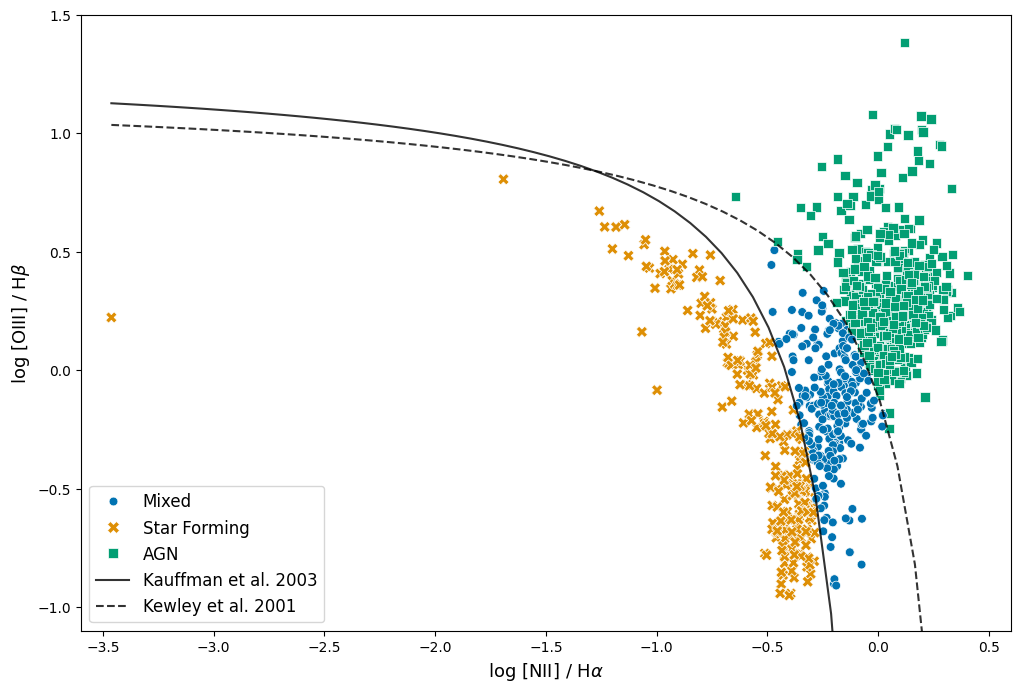

In [35]:
plt.figure(figsize=(12, 8))

plt.xlim(-3.6, 0.6)
plt.ylim(-1.1, 1.5)

sns.scatterplot(data=results, x='nii_h_alpha_log', y='oiii_h_beta_log', palette='colorblind', 
                hue='BPT final', style='BPT final', size='BPT final', sizes=(90, 40))

# ------------------------------------------------------------------------------------------------
# Kauffman
x_to_plot = np.linspace(results['nii_h_alpha_log'].min(), 0)
plt.plot(x_to_plot, 0.61 / (x_to_plot - 0.05) + 1.3, label='Kauffman et al. 2003', 
         linewidth=1.5, alpha=0.8, c='k', linestyle='solid')

# ------------------------------------------------------------------------------------------------
# Kewley
x_to_plot_1 = np.linspace(results['nii_h_alpha_log'].min(), results['nii_h_alpha_log'].max())
plt.plot(x_to_plot_1, 0.61 / (x_to_plot_1 - 0.47) + 1.19, label='Kewley et al. 2001', 
         linewidth=1.5, alpha=0.8, c='k', linestyle='dashed')

# ------------------------------------------------------------------------------------------------

plt.xlabel(r'log [NII] / H$\alpha$', fontsize=13)
plt.ylabel(r'log [OIII] / H$\beta$', fontsize=13)

plt.legend(loc='lower left', fontsize=12)

plt.show()

## WISE color-color diagram

__1)__ For the example galaxies selected from SDSS database in Part I, finde the corresponding WISE colors using WISE fluxes from Cross-identifications link.

In [38]:
#Same quary as on top
results

,plate,mjd,fiberid,z,subclass,e_bv_sfd,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,w1mpro,w2mpro,w3mpro,nii_h_alpha,nii_h_alpha_log,oiii_h_beta,oiii_h_beta_log,BPT Kauffman,BPT Kewley,BPT final
0,1666,52991,11,0.017784,AGN BROADLINE,0.180392,555.7126,162.12570,102.83580,404.6120,10.586,10.676,8.993,0.728096,-0.137811,0.634297,-0.197708,AGN,Star Forming,Mixed
1,1309,52762,439,0.005701,STARFORMING,0.015393,1039.2140,175.08380,57.58485,423.8870,9.426,9.202,5.031,0.407892,-0.389455,0.328899,-0.482938,Star Forming,Star Forming,Star Forming
2,775,52295,410,0.010826,STARBURST,0.009580,5745.3640,1461.34500,1267.27900,1467.1250,14.356,14.195,9.871,0.255358,-0.592850,0.867200,-0.061881,Star Forming,Star Forming,Star Forming
3,564,52224,99,0.013246,STARFORMING,0.050521,1695.5870,501.81610,726.29080,347.2574,14.369,14.340,11.500,0.204801,-0.688669,1.447325,0.160566,Star Forming,Star Forming,Star Forming
4,2241,54169,598,0.023741,BROADLINE,0.008973,117.6491,43.39046,253.74640,253.2280,13.261,13.236,11.737,2.152401,0.332923,5.847977,0.767006,AGN,AGN,AGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,2134,53876,361,0.014400,BROADLINE,0.023690,315.1962,120.45240,191.52580,465.0980,10.403,10.457,9.421,1.475583,0.168963,1.590054,0.201412,AGN,AGN,AGN
1046,308,51662,191,0.005535,AGN,0.044501,803.5585,216.12770,345.87280,853.2526,10.203,10.221,8.550,1.061843,0.026060,1.600317,0.204206,AGN,AGN,AGN
1047,537,52027,240,0.005224,STARFORMING,0.037490,4874.0800,983.14730,551.11520,2755.9030,10.123,10.057,6.648,0.565420,-0.247629,0.560562,-0.251376,AGN,Star Forming,Mixed
1048,536,52024,40,0.005190,STARFORMING,0.037490,4881.9670,840.70630,520.56640,2740.8870,10.123,10.057,6.648,0.561431,-0.250704,0.619201,-0.208168,AGN,Star Forming,Mixed


__2)__ Assign classes (AGN & (u)LIRGS, Spheroids, Intermidiate disk and SF disks) to all objects in the sample using the thresholds from the image on the bottom right (dashed lines. How do these classes compare to ones obtained using the BPT diagram from part I?

In [39]:
def wise_color_color(w1, w2, w3):
    '''
    Returns the class according to Figure 11b in Jarret et al. 2017
    '''
    color_x = w2 - w3
    color_y = w1 - w2

    if color_y >= 0.8:
        return 'AGN & (u)LIRGs'
    elif color_y < 0.8 and color_x < 2.0:
        return 'Spheroids'
    elif color_y < 0.8 and color_x > 3.5:
        return 'SF Disks'
    else:
        return 'Inter. Disks'

In [41]:
results['wise class'] = results.apply(lambda x: wise_color_color(x['w1mpro'], x['w2mpro'], x['w3mpro']), axis=1)
Counter(results['wise class'])

Counter({'Spheroids': 445,
         'Inter. Disks': 314,
         'SF Disks': 286,
         'AGN & (u)LIRGs': 5})

In [42]:
results['w1-w2'] = results.apply(lambda x: x['w1mpro'] - x['w2mpro'], axis=1)
results['w2-w3'] = results.apply(lambda x: x['w2mpro'] - x['w3mpro'], axis=1)

__3)__ Locate one random object on the WISE color-color plot having W1-W2>=0.8 (Assef et al. 2013) and address the following: 

* Where is the object located in this plot? Mark it clearly on the graph.
* Does it agree with the optical classification from BPT doagram?
* Draw some conclusions about the type of AGN using the WISE color-color plot.

In [44]:
random_obj = results.loc[results['w1-w2']>=0.8].sample(n=1, random_state=42)
random_obj

,plate,mjd,fiberid,z,subclass,e_bv_sfd,h_alpha_flux,h_beta_flux,oiii_5007_flux,nii_6584_flux,...,nii_h_alpha,nii_h_alpha_log,oiii_h_beta,oiii_h_beta_log,BPT Kauffman,BPT Kewley,BPT final,wise class,w1-w2,w2-w3
424,1776,53858,632,0.021559,STARBURST,0.025653,16633.67,3754.218,4133.134,6907.328,...,0.415262,-0.381678,1.100931,0.04176,AGN,Star Forming,Mixed,AGN & (u)LIRGs,0.882,3.696


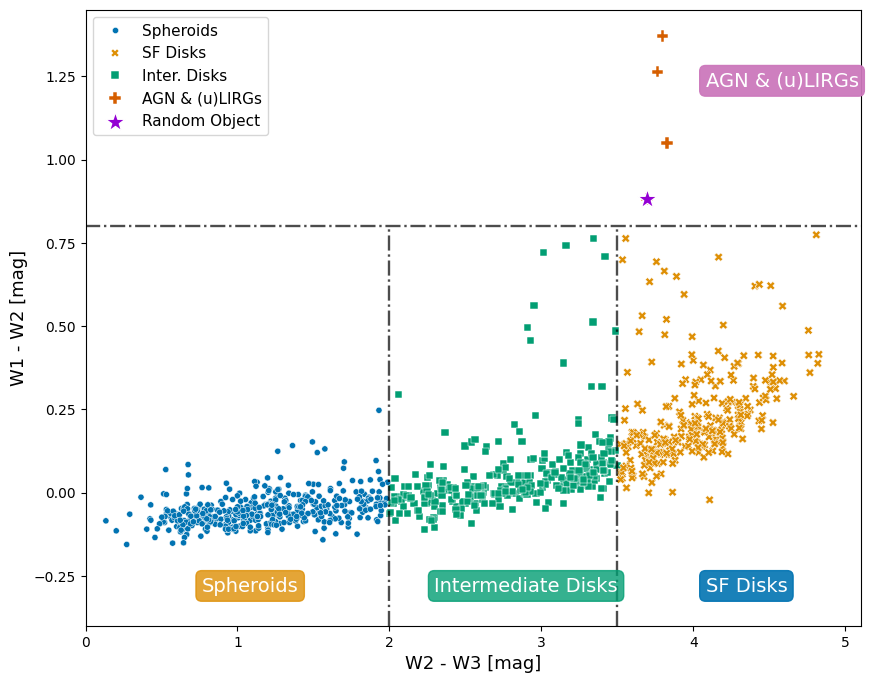

In [45]:
fig, ax = plt.subplots(figsize=(10, 8))

plt.ylim(-0.4, 1.45)
plt.xlim(0, 5.1)

sns.scatterplot(data=results, x='w2-w3', y='w1-w2', palette='colorblind', 
                hue='wise class', style='wise class', size='wise class', sizes=(70, 20))

plt.scatter(random_obj['w2-w3'], random_obj['w1-w2'], c='darkviolet', 
            edgecolors='white', marker='*', s=230, label='Random Object')

plt.vlines([2.0, 3.5], -0.4, 0.8, 
           linestyles='dashdot', color='k', alpha=0.7, linewidth=1.7)
plt.hlines(0.8, -0.5, 5.5, linestyles='dashdot', color='k', alpha=0.7, linewidth=1.7)

props = dict(boxstyle='round', color='#cc78bc', alpha=0.95)
ax.text(0.8, 0.9, 'AGN & (u)LIRGs', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props, color='white')

props_1 = dict(boxstyle='round', color='#029e73', alpha=0.8)
ax.text(0.45, 0.08, 'Intermediate Disks', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props_1, color='white')

props_2 = dict(boxstyle='round', color='#de8f05', alpha=0.8)
ax.text(0.15, 0.08, 'Spheroids', transform=ax.transAxes, fontsize=14,
       verticalalignment='top', bbox=props_2, color='white')

props_3 = dict(boxstyle='round', color='#0173b2', alpha=0.9)
ax.text(0.8, 0.08, 'SF Disks', transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props_3, color='white')

plt.xlabel(r'W2 - W3 [mag]', fontsize=13)
plt.ylabel(r'W1 - W2 [mag]', fontsize=13)

plt.legend(loc='upper left', fontsize=11)

plt.show()